# Variability analysis

This notebook generates 'underway' plots for the Denman/Shackleton region. Model output is used to generate plots of oceangraphic conditions for a certain day.

**Requirements:** All notebooks need to run on the `conda/analysis3` kernel. This is the most recent stable release of the `conda` environment curated by the CLEX CMS team.

First, we load any required modules. The following are pretty standard:

In [84]:
# import intake
import numpy as np

import xarray as xr
# import cf_xarray as cfxr
from xgcm import Grid
from pyproj import Transformer
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# from dask.distributed import Client

These modules are more optional:

In [8]:
import cmocean as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes
import glob                                       # If you need to search file systems
import cartopy.crs as ccrs                        # For making maps
import cartopy.feature as cft                     # For adding features to maps

I found that sometimes dask doesn't play nice with xgcm, so let's not use dask for now. It's probably a version issue, but for now let's not use dask.

In [9]:
# client = Client()
# client

You will need to nominate a catalog from which to load your data. Unless there is a pressing need, it is best to use the default catalog:

In [10]:
# catalog = intake.cat.access_nri

Start by loading the ROMS output.

In [70]:
# simple method for loading his files - replace with intake catalog method.and
import glob
# FilePath='/g/data/jk72/deg581/shacom/mdl/shackleton_v4/' # Truth file settings
FilePath='../../shackleton-setup/notebooks/'#%/g/data/jk72/deg581/shacom/mdl/shackleton_v4/' # Truth file settings
prefix='roms_his_'


filelist = glob.glob(FilePath+prefix+'002*.nc')
ds = xr.open_mfdataset(filelist,{'ocean_time':1}, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right')

Prepare the ROMS dataset for use.

In [71]:
# do special processing for ROMS formatting

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    grid = Grid(ds,
                coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
                'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
                'Z':{'center':'s_rho', 'outer':'s_w'}},
                periodic=[])

    

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + (ds.zeta+ds.zice) * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + (ds.zeta+ds.zice) * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta+ds.zice + (ds.zeta+ds.zice + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta+ds.zice + ds.h) + ds.zeta + ds.zice

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut


ds = processROMSGrid(ds)
grid = makeROMSGridObject(ds)

/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a se

Make some other masks that we might need.

In [13]:
mask_zice = ds.mask_rho.where((ds.zice < 0)&(ds.mask_rho==1),0)
mask_ziceNaN = mask_zice.where(mask_zice==1,np.nan)

Make a climatology from the input files, and add a new coordinate which has date values for 2025 for the dayofyear index.

In [ ]:

ds_clima = ds.groupby('ocean_time.dayofyear').mean('ocean_time')

dates = np.array([np.datetime64(f"{2025}-01-01") + np.timedelta64(int(doy - 1), "D") for doy in ds_clima.dayofyear.values])



Make new dataset with just the variables we're interested in.

In [ ]:

my = (ds_clima.m*60*60*24*365) # make melt rate into m/year

ubar = grid.interp(ds_clima.ubar, 'X')
vbar = grid.interp(ds_clima.vbar, 'Y')


u_rho = grid.interp(ds_clima.u, 'X')
v_rho = grid.interp(ds_clima.v, 'Y')

temp = ds_clima.temp
salt = ds_clima.salt



# Create a new dataset
ds_shackleton = xr.Dataset(
    {
        "my": my,
        "ubar": ubar,
        "vbar": vbar,
        "u_rho":u_rho,
        "v_rho": v_rho,
        "temp": temp,
        "salt":salt,
        "z_rho0": ds.z_rho0,
        # "lon_rho": (["eta_rho", "xi_rho"], lon_rho),
        # "lat_rho": (["eta_rho", "xi_rho"], lat_rho),
        "x_rho":  ds.x_rho,
        "y_rho": ds.y_rho,
        "mask_rho":ds.mask_rho,
        "mask_zice":mask_zice,
        "mask_ziceNaN":mask_ziceNaN,
        "h": ds.h,
        "zice": ds.zice,
        "angle": ds.angle,
    },
    coords={
        "dayofyear": ds_clima.dayofyear,
        "date": dates.astype("datetime64[ns]"),
        "xi_rho": ds_clima.xi_rho,
        "eta_rho": ds_clima.eta_rho,
        "s_rho": ds_clima.s_rho,
    }
)
# by adding both dayofyear and date as coords, we can index either of them.


/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a se

A seasonal circulation plot will give us an idea of seasonal variability - lets use xgcm to extract a chosen depth

/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 th

ValueError: x must be one of None, 'eta_rho', 'x_rho', 'xi_rho', 'y_rho', 'z_rho0'. Received 'lon_rho' instead.

<Figure size 640x480 with 0 Axes>

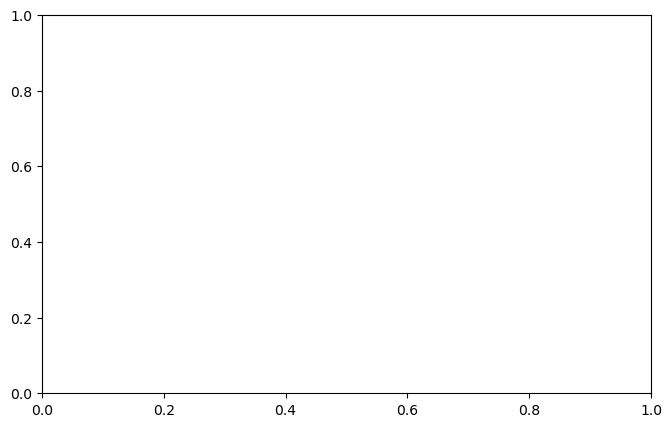

In [102]:
res=5 #arrow resolution

# define time periods
mam_period=slice(60,150)
jja_period=slice(150,240)
son_period=slice(240,330)
djf_period1=slice(330,366)
djf_period2=slice(0,60)


# make time averages for 
#velocities
us_rho_s1   = (xr.concat( [ds_shackleton.u_rho.sel(dayofyear=djf_period1),ds_shackleton.u_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
vs_rho_s1   = (xr.concat( [ds_shackleton.v_rho.sel(dayofyear=djf_period1),ds_shackleton.v_rho.sel(dayofyear=djf_period2)],dim='dayofyear')).mean(dim='dayofyear')
us_rho_s2   = ds_shackleton.u_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
vs_rho_s2   = ds_shackleton.v_rho.sel(dayofyear=mam_period).mean(dim='dayofyear')   
us_rho_s3   = ds_shackleton.u_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
vs_rho_s3   = ds_shackleton.v_rho.sel(dayofyear=jja_period).mean(dim='dayofyear')   
us_rho_s4   = ds_shackleton.u_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   
vs_rho_s4   = ds_shackleton.v_rho.sel(dayofyear=son_period).mean(dim='dayofyear')   

#temperatures
temp_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
temp_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=mam_period).mean(dim='dayofyear')
temp_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=jja_period).mean(dim='dayofyear')
temp_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.temp.sel(dayofyear=son_period).mean(dim='dayofyear')
#salinities
salt_s1 = ( xr.concat( [ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period1),
                        ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=djf_period2)],dim='dayofyear') ).mean(dim='dayofyear')
salt_s2 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=mam_period).mean(dim='dayofyear')
salt_s3 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=jja_period).mean(dim='dayofyear')
salt_s4 = ds_shackleton.mask_rho*(ds_shackleton.mask_rho)*ds_shackleton.salt.sel(dayofyear=son_period).mean(dim='dayofyear')


def extract_and_rotate(grid,ds,temp, salt, u, v, choose_depth):
    """
    Extracts temperature, salinity, and velocity components at a specified depth,
    and rotates velocity to lon/lat directions.

    Parameters:
    grid (xgcm.Grid): The grid object for vertical interpolation.
    ds (xarray.Dataset): The dataset containing ocean data.
    temp (xarray.DataArray): Temperature field.
    salt (xarray.DataArray): Salinity field.
    u (xarray.DataArray): U-velocity field.
    v (xarray.DataArray): V-velocity field.
    choose_depth (float): Depth level to extract (positive value for depth).

    Returns:
    tuple: (temp_depth, salt_depth, u_lonlat, v_lonlat) interpolated at the given depth.
    """
    temp_depth = grid.transform(temp, 'Z', np.array([-choose_depth]),
                                target_data=ds.z_rho0, method='linear').squeeze()
    salt_depth = grid.transform(salt, 'Z', np.array([-choose_depth]),
                                target_data=ds.z_rho0, method='linear').squeeze()

    u_depth = grid.transform(u, 'Z', np.array([-choose_depth]),
                              target_data=ds.z_rho0, method='linear').squeeze()
    v_depth = grid.transform(v,'Z', np.array([-choose_depth]),
                              target_data=ds.z_rho0, method='linear').squeeze()

    
    # Rotate velocity components
    U = u_depth + 1j * v_depth  # Convert to complex form
    rotation_factor = np.exp(1j * ds.angle)  # Compute rotation factor
    rotated_velocity = U * rotation_factor
    
    # Extract real and imaginary parts as rotated velocity components
    u_lonlat = np.real(rotated_velocity)
    v_lonlat = np.imag(rotated_velocity)
    
    return temp_depth, salt_depth, u_lonlat, v_lonlat

temp_depth_s1, salt_depth_s1, u_lonlat_s1, v_lonlat_s1 = extract_and_rotate(grid,ds_shackleton,temp_s1, salt_s1, us_rho_s1, vs_rho_s1, 400)
temp_depth_s2, salt_depth_s2, u_lonlat_s2, v_lonlat_s2 = extract_and_rotate(grid,ds_shackleton,temp_s2, salt_s2, us_rho_s2, vs_rho_s2, 400)
temp_depth_s3, salt_depth_s3, u_lonlat_s3, v_lonlat_s3 = extract_and_rotate(grid,ds_shackleton,temp_s3, salt_s3, us_rho_s3, vs_rho_s3, 400)
temp_depth_s4, salt_depth_s4, u_lonlat_s4, v_lonlat_s4 = extract_and_rotate(grid,ds_shackleton,temp_s4, salt_s4, us_rho_s4, vs_rho_s4, 400)


plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,10])
ax = None

gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.035, hspace=0.035)

choose_depth=15

ax=fig.add_subplot(gs[0,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s1.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-2.1,-1.75,.05),add_colorbar=False)

ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], 
          u_lonlat_s1.isel(s_rho=choose_depth).values[0::res,0::res], v_lonlat_s1.isel(s_rho=choose_depth).values[0::res,0::res],scale=2.5)

co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'a  DJF (DOY 330 to 60)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[0,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s2.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal', levels=np.arange(-2.1,-1.75,.05),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s2.isel(s_rho=choose_depth).values[0::res,0::res], 
          v_lonlat_s2.isel(s_rho=choose_depth).values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'b  MAM (DOY 60 to 150)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,0])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s3.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-2.1,-1.75,.05),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s3.isel(s_rho=choose_depth).values[0::res,0::res], 
          v_lonlat_s3.isel(s_rho=choose_depth).values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'c  JJA (DOY 150 to 240)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')



##########

ax=fig.add_subplot(gs[1,1])
#(lima.astype('uint8')).plot.imshow()
im2 = temp_depth_s4.plot.contourf(ax=ax,x='lon_rho',y='lat_rho',cmap='cmo.thermal',levels=np.arange(-2.1,-1.75,.05),add_colorbar=False)
ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res], ds_shackleton.lat_rho.values[0::res,0::res], u_lonlat_s4.isel(s_rho=choose_depth).values[0::res,0::res], 
          v_lonlat_s4.isel(s_rho=choose_depth).values[0::res,0::res],scale=2.5)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_shackleton.lon_rho,ds_shackleton.lat_rho,ds_shackleton.zice*ds_shackleton.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)

# ax.set_xlim((1.68e6,2.45e6))
# ax.set_ylim((.52e6,1.0e6))

ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('')
ax.text(0.01, 0.99, 'd  SON (DOY 240 to 330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="4%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,0.06, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'Potential temperature ($^\circ$C)')#,fontsize=14)
fig.suptitle('Mid-depth temperature and velocities')

In [95]:

temp_s1

<xarray.DataArray (eta_rho: 310, xi_rho: 295, dayofyear: 19, s_rho: 31)> Size: 431MB
dask.array<concatenate, shape=(310, 295, 19, 31), dtype=float64, chunksize=(310, 295, 1, 31), chunktype=numpy.ndarray>
Coordinates:
    x_rho      (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    y_rho      (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
  * xi_rho     (xi_rho) int64 2kB 0 1 2 3 4 5 6 ... 288 289 290 291 292 293 294
  * eta_rho    (eta_rho) int64 2kB 0 1 2 3 4 5 6 ... 303 304 305 306 307 308 309
  * dayofyear  (dayofyear) int64 152B 331 336 341 346 351 356 ... 36 41 46 51 56
  * s_rho      (s_rho) float64 248B -0.9839 -0.9516 ... -0.04839 -0.01613
    z_rho0     (eta_rho, xi_rho, s_rho) float64 23MB dask.array<chunksize=(310, 295, 31), meta=np.ndarray>

In [18]:
ds_shackleton

<xarray.Dataset> Size: 3GB
Dimensions:       (eta_rho: 310, xi_rho: 295, date: 73, s_rho: 31)
Coordinates:
    x_rho         (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    y_rho         (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    dayofyear     (date) int64 584B 1 6 11 16 21 26 ... 336 341 346 351 356 361
  * date          (date) datetime64[ns] 584B 2025-01-01 ... 2025-12-27
  * xi_rho        (xi_rho) int64 2kB 0 1 2 3 4 5 6 ... 289 290 291 292 293 294
  * eta_rho       (eta_rho) int64 2kB 0 1 2 3 4 5 6 ... 304 305 306 307 308 309
  * s_rho         (s_rho) float64 248B -0.9839 -0.9516 ... -0.04839 -0.01613
    z_rho0        (eta_rho, xi_rho, s_rho) float64 23MB dask.array<chunksize=(310, 295, 31), meta=np.ndarray>
Data variables: (12/13)
    my            (date, eta_rho, xi_rho) float32 27MB dask.array<chunksize=(1, 310, 295), meta=np.ndarray>
    ubar          (date, eta_rho, xi_rho) float32 27MB dask.array<chunksize=(1, 310, 295), meta=np.ndarray>
    vbar          (date, eta_rho, xi_rho) float32 27MB dask.array<chunksize=(1, 310, 295), meta=np.ndarray>
    u_rho         (date, s_rho, eta_rho, xi_rho) float32 828MB dask.array<chunksize=(1, 31, 310, 295), meta=np.ndarray>
    v_rho         (date, s_rho, eta_rho, xi_rho) float32 828MB dask.array<chunksize=(1, 31, 310, 295), meta=np.ndarray>
    temp          (date, s_rho, eta_rho, xi_rho) float32 828MB dask.array<chunksize=(1, 31, 310, 295), meta=np.ndarray>
    ...            ...
    mask_rho      (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    mask_zice     (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    mask_ziceNaN  (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    h             (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    zice          (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    angle         (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>

Now plot standard deviation in temp/salt at different depths

In [ ]:
STOP

Now let's make some plots for analysis of daily conditions (from the climatology!)

First, set the date:

In [ ]:
choose_day = '2025-03-01'


Spatial maps at current date

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Text(0.5, 1.0, 'Potential temperature for day: 2025-03-01\nwith currents at: 10 m depth')

<Figure size 640x480 with 0 Axes>

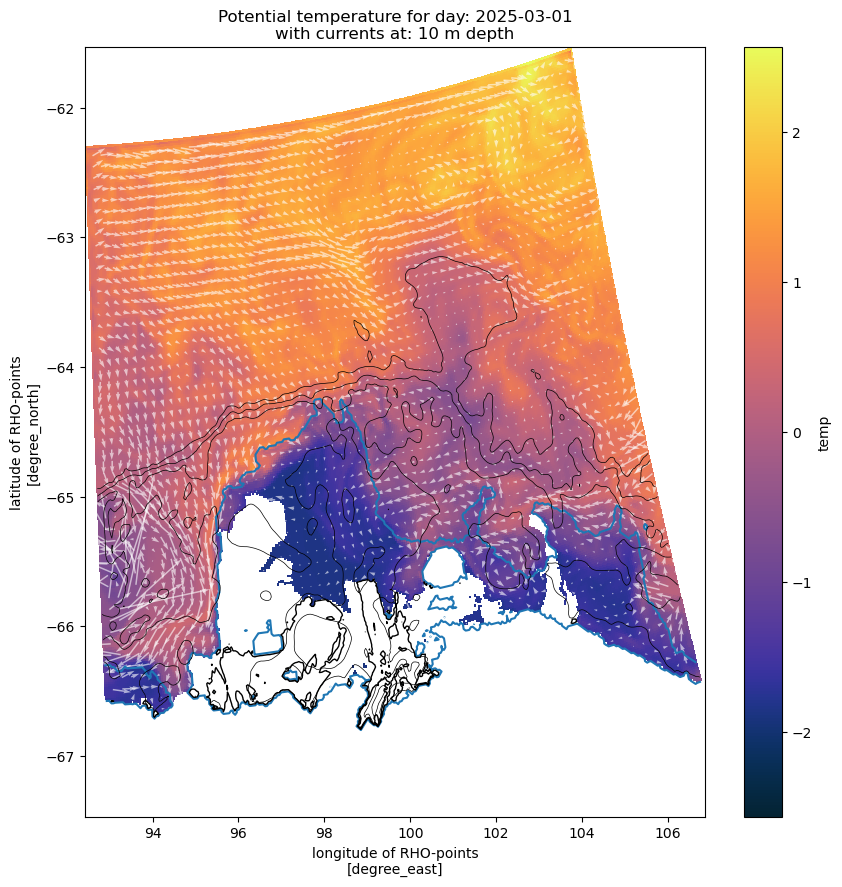

In [ ]:
choose_depth = 10 #metres

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None


ax = fig.add_subplot(gs[0,0])

#extract data at nearest depth

temp_depth = grid.transform(ds_shackleton.temp.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

u_depth = grid.transform(ds_shackleton.u.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

v_depth = grid.transform(ds_shackleton.v.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

U = u_depth + 1j*v_depth
rotation_factor = np.exp(1j*ds_shackleton.angle)
rotated_velocity = U * rotation_factor
# Extract the real and imaginary parts (rotated u and v components)
u_lonlat = np.real(rotated_velocity)
v_lonlat = np.imag(rotated_velocity)


im = temp_depth.plot(x='lon_rho',y='lat_rho',cmap='cmo.thermal')
res=5
qu = ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res],ds_shackleton.lat_rho.values[0::res,0::res],u_lonlat[0::res,0::res],v_lonlat[0::res,0::res],scale=5,color='w',alpha=0.6)

# add decorations
(ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='C0',levels=[-1,0],linestyles='-')
co = (ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=[-1000,-500,-250],linestyles='-',linewidths=1)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=[500,1000,1500],linestyles='-',linewidths=0.5)

title = 'Potential temperature for day: '+choose_day+'\n'+'with currents at: '+str(choose_depth)+' m depth'
ax.set_title(title)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Text(0.5, 1.0, 'Potential temperature for day: 2025-03-01\nwith currents at: 450 m depth')

<Figure size 640x480 with 0 Axes>

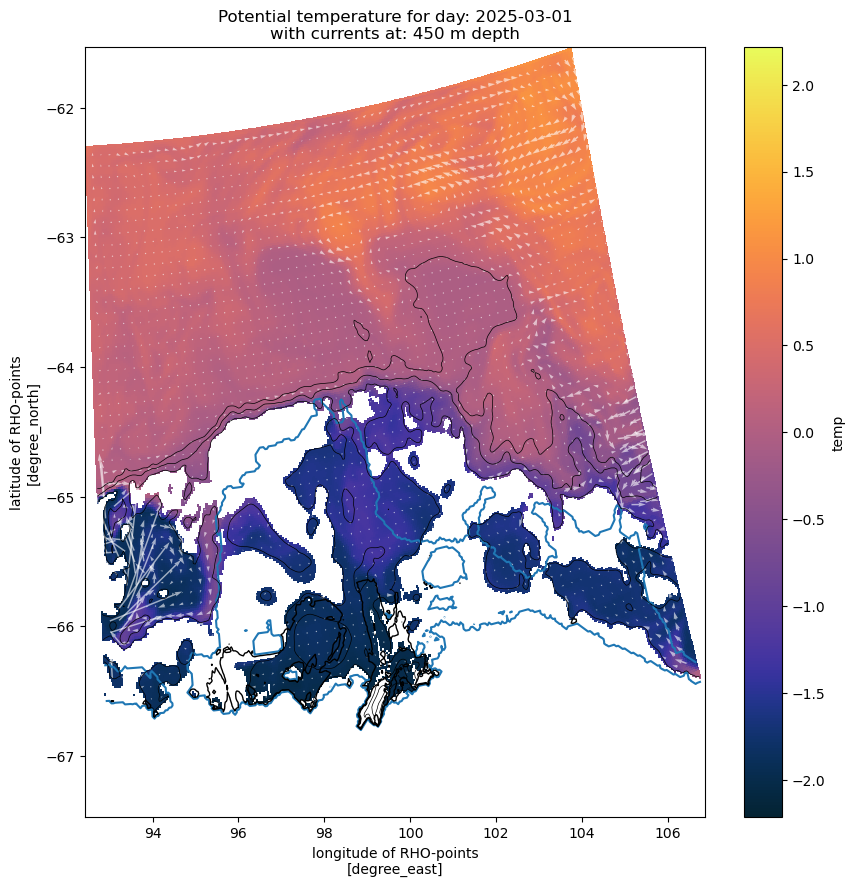

In [ ]:
choose_depth = 450 #metres
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None


ax = fig.add_subplot(gs[0,0])

#extract data at nearest depth

temp_depth = grid.transform(ds_shackleton.temp.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

u_depth = grid.transform(ds_shackleton.u.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

v_depth = grid.transform(ds_shackleton.v.sel(date=choose_day,method='nearest'),
                         'Z', np.array([-choose_depth]),
                         target_data=ds_shackleton.z_rho0,method='linear').squeeze()

U = u_depth + 1j*v_depth
rotation_factor = np.exp(1j*ds_shackleton.angle)
rotated_velocity = U * rotation_factor
# Extract the real and imaginary parts (rotated u and v components)
u_lonlat = np.real(rotated_velocity)
v_lonlat = np.imag(rotated_velocity)


im = temp_depth.plot(x='lon_rho',y='lat_rho',cmap='cmo.thermal')
res=5
qu = ax.quiver(ds_shackleton.lon_rho.values[0::res,0::res],ds_shackleton.lat_rho.values[0::res,0::res],u_lonlat[0::res,0::res],v_lonlat[0::res,0::res],scale=5,color='w',alpha=0.6)

# add decorations
(ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='C0',levels=[-1,0],linestyles='-')
co = (ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=[-1000,-500,-250],linestyles='-',linewidths=1)
co2 = (ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=[500,1000,1500],linestyles='-',linewidths=0.5)

title = 'Potential temperature for day: '+choose_day+'\n'+'with currents at: '+str(choose_depth)+' m depth'
ax.set_title(title)



For a certain longitude, extract profiles. Because the grid is on the polarstereographic cartesian projection, model eta/xi coordinates do not align with lines of latitude or longitude. As such, we need to extract the closest points. We use a function that looks for the closest point at each latitude, then extracts all of these points (indices) from the dataset.

In [ ]:

def extract_along_longitude(ds, choose_lon, var_name):
    """
    Extract values from a 3D ROMS variable along the closest longitude at each latitude.
    
    Parameters:
    ds (xarray.Dataset): The ROMS dataset containing 'lon_rho' and the variable of interest.
    choose_lon (float): The target longitude for extraction.
    var_name (str): The name of the 3D variable to extract (e.g., 'temp', 'salt', 'zeta').

    Returns:
    xarray.DataArray: Extracted values along the closest longitude at each latitude.
    """
    # Get longitude grid
    lon_rho = ds['lon_rho'].values

    # Compute absolute differences to target longitude
    lon_index_2d = np.abs(lon_rho - choose_lon)

    # Initialize an array for closest longitude indices (one per latitude row)
    lon_index = np.zeros(lon_index_2d.shape[1], dtype=int)

    # Loop over each latitude row and find the closest longitude index
    for ii in range(lon_index_2d.shape[1]):
        lon_index[ii] = lon_index_2d[:, ii].argmin()

    # Create latitude indices (row indices)
    lat_index = np.arange(lon_index_2d.shape[1])

    # Extract the 3D variable
    variable_3d = ds[var_name]

    # Use xarray advanced indexing to extract the values
    extracted_values = variable_3d.isel(eta_rho=(['points'], lon_index), xi_rho=(['points'], lat_index))

    return extracted_values


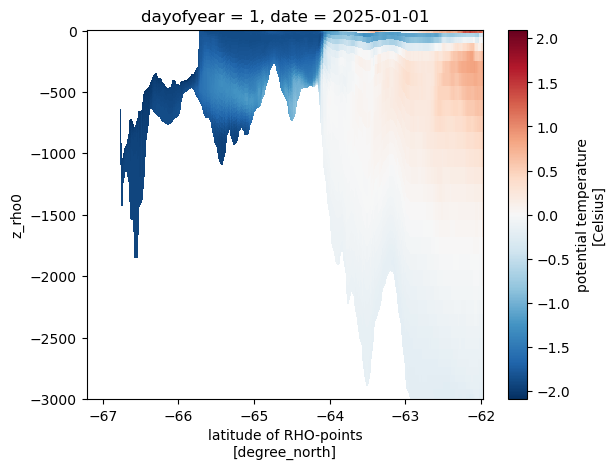

In [ ]:
extracted_data = extract_along_longitude(ds_shackleton, choose_lon=99.25, var_name='temp')

# This will return an xarray DataArray with dimensions (time, points)
extracted_data.isel(date=0).plot(y='z_rho0',x='lat_rho')

So let's make some nice plots of cross-shelf properties.

Text(0, 0.5, 'Depth (m)')

<Figure size 640x480 with 0 Axes>

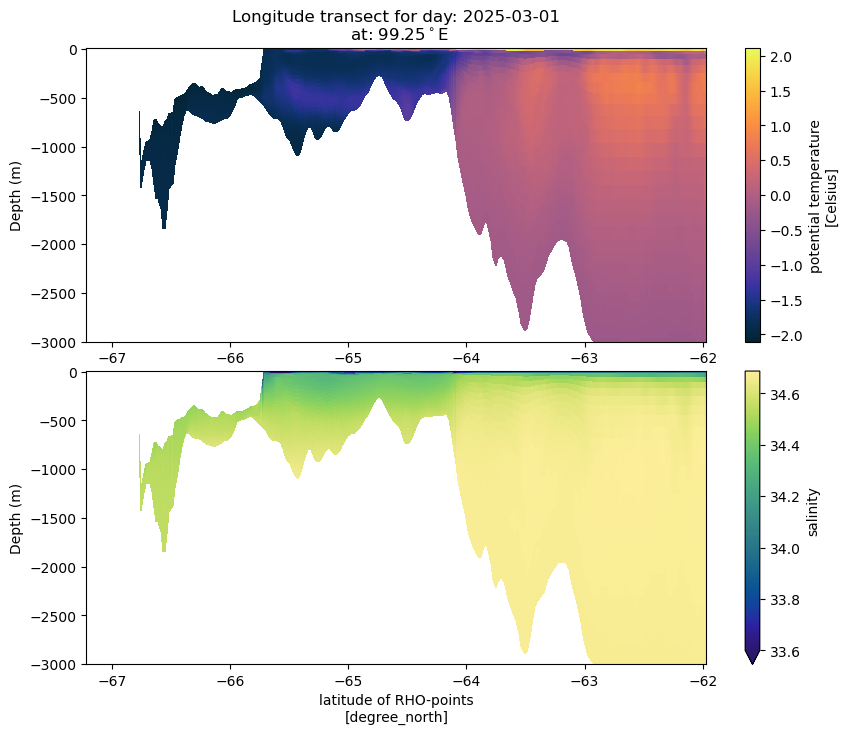

In [ ]:
lon_transect = 99.25 #deg
extracted_data = extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='temp')

# This will return an xarray DataArray with dimensions (time, points)
extracted_data.isel(date=0).plot(y='z_rho0',x='lat_rho')

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.17, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,8])
ax = None


ax = fig.add_subplot(gs[0,0])

extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='temp').sel(
                    date=choose_day,method='nearest').plot(y='z_rho0',x='lat_rho',cmap='cmo.thermal')

title = 'Longitude transect for day: '+choose_day+'\n'+' at: '+str(lon_transect)+r'$^\circ$E'
ax.set_title(title)
ax.set_ylabel('Depth (m)')

ax = fig.add_subplot(gs[1,0])

extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='salt').sel(
                    date=choose_day,method='nearest').plot(y='z_rho0',x='lat_rho',cmap='cmo.haline',vmin=33.6)
ax.set_title('')
ax.set_ylabel('Depth (m)')



Text(0, 0.5, 'Depth (m)')

<Figure size 640x480 with 0 Axes>

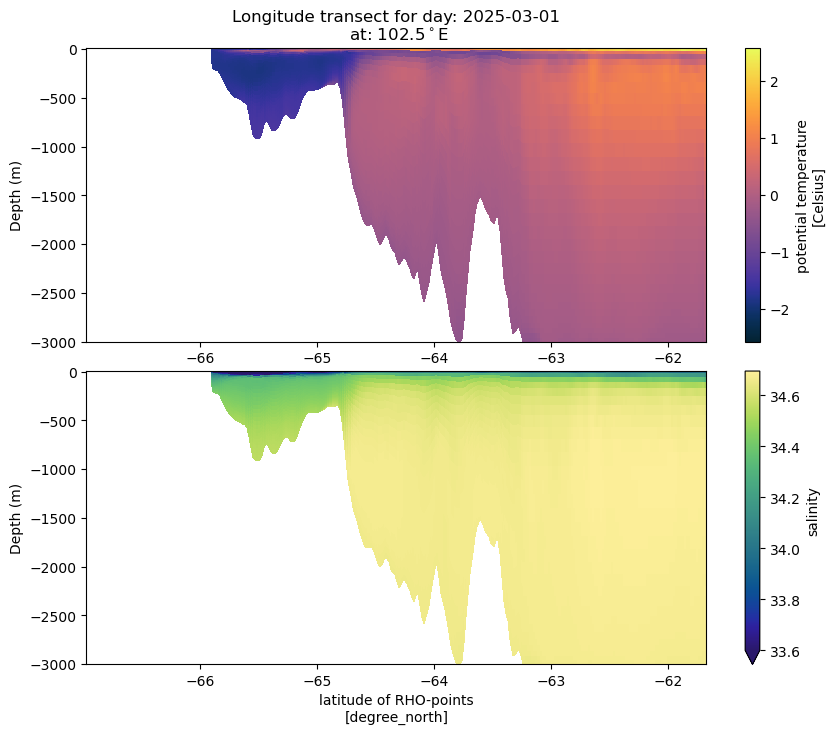

In [ ]:
lon_transect = 102.5 #deg
extracted_data = extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='temp')

# This will return an xarray DataArray with dimensions (time, points)
extracted_data.isel(date=0).plot(y='z_rho0',x='lat_rho')

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.17, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,8])
ax = None


ax = fig.add_subplot(gs[0,0])

extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='temp').sel(
                    date=choose_day,method='nearest').plot(y='z_rho0',x='lat_rho',cmap='cmo.thermal')

title = 'Longitude transect for day: '+choose_day+'\n'+' at: '+str(lon_transect)+r'$^\circ$E'
ax.set_title(title)
ax.set_ylabel('Depth (m)')

ax = fig.add_subplot(gs[1,0])

extract_along_longitude(ds_shackleton, choose_lon=lon_transect, var_name='salt').sel(
                    date=choose_day,method='nearest').plot(y='z_rho0',x='lat_rho',cmap='cmo.haline',vmin=33.6)
ax.set_title('')
ax.set_ylabel('Depth (m)')

